In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

In [86]:
%matplotlib inline
from __future__ import division
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Mid-term exam

## 1.

Consider the joint density $f(x, u) = 1(0<u<\pi(x))$, the conditional density should be:

i. given x, u should satisfy a uniform distribution $U(0, \pi(x))$

ii. given u, x should satisfy a uniform distribution on $A_u = \{x:\pi(x) > u \}$

Thus, the algorithm of the Gibbs sampler:

1. sample $x_0$ from a proposed initial density $q_0(x)$
2. sample u from $U(0, \pi(x))$
3. sample x from $U(A_u)$
4. iterate 2 and 3 until convergence is reached and enough samples are generated

Specifically, to sample $\pi(x) \propto 1/(1+x^4)$

In [3]:
def pi(x):
    return 1/(1+x**4)

From the above algorithm and joint density, $u|_x \sim U(0, 1/(1+x^4))$:

In [4]:
def draw_u(x):
    u = np.random.uniform()
    while u >= pi(x):
        u = np.random.uniform()
    return u

And $x|_u ~ U(-\pi^{-1}(u),\pi^{-1}(u))$, where $\pi^{-1}(u)$ is defined by:

\begin{equation}
\pi^{-1}(u) = (\frac{1}{u} - 1)^{1/4}
\end{equation}

In [13]:
def draw_x(u):
    sign = np.random.choice([1, -1])
    x = np.random.uniform(-pow(1/u-1, 1/4), pow(1/u-1, 1/4))
    return sign*x

Use this Gibbs sampler to generate a million samples:

In [63]:
u = np.random.uniform()
N = 1000000
samples = np.zeros(N)
for i in range(N):
    x = draw_x(u)
    samples[i] = x
    u = draw_u(x)

Plot the histogram of histogram of the samples, tt can be shown that this is consistent with the actual distribution:

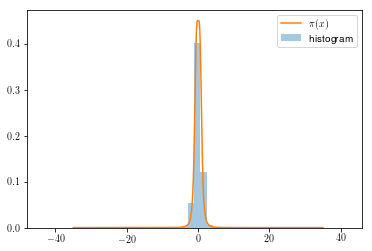

In [125]:
sns.distplot(samples, kde=False, norm_hist=True, label="histogram")
x = np.linspace(-35, 35,1000)
plt.plot(x, 1/(1+x**4) * np.sqrt(2) / np.pi, label='\pi(x)')
plt.legend()
plt.show()

Compute the Monte Carlo integral for $I = \int x^2 \pi(x) dx$, plot the convergence curve

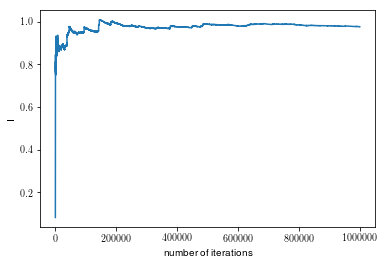

In [102]:
I = samples**2
for i in range(1, N):
    I[i] = (I[i-1]*i + samples[i]**2)/(i+1) #fast, probably unstable way to compute average vs iteration
    
plt.plot(range(N), I)
plt.xlabel("number of iterations")
plt.ylabel("I")
plt.show()

Use the first 200000 iterations as a burn-in simulation and compute the MC approximation $\hat{I}_N = \sum_{i}^n x_i y_i / n$ to estimate variance:

In [103]:
(samples**2)[200000:].mean()

0.97173092278310669

Note that I assume $\pi(x)$ is a probability function. Thus this MC integration is close to the actual integration which is:

\begin{equation}
I = \frac{\int x^2 \pi(x) dx}{\int \pi(x) dx} = 1
\end{equation}

## 2.
From Bayes' theory:

\begin{align}
f(\mu, \lambda \ | \ data) &\propto \prod_{i=1}^n g(x_i \ | \ \mu, \lambda) \cdot f(\mu) \cdot f(\lambda) \\
                        &=  \lambda^{n/2} e^{\lambda \sum_{i=1}^n -(x_i-\mu)^2 / 2} \cdot \frac{1}{ \tau} e^{-\mu^2 / 2\tau^2} \cdot \lambda^{a-1} e^{-\lambda b}
\end{align}

Since the size of the samples is rather small, I picked larg $\tau$ and small a and b so that the Markov chain is less sensitive to the coefficients.

In [109]:
tau = 10; a = 2; b = 3 
n = 51

Rearange $f(\mu, \lambda \ | \ data)$ and get conditional densities for $\mu$ and $\lambda$:

\begin{align}
p(\mu | \lambda, data) &\propto e^{\lambda \sum_{i=1}^n -(x_i-\mu)^2 / 2} \cdot  e^{-\mu^2 / 2\tau^2}\\
                        &\propto e^{-\frac{1}{2} (\mu - \frac{\lambda n \bar{x}}{1/\tau^2 + n \lambda})^2 \cdot (1/\tau^2 + n \lambda)}
\end{align}

$\mu |_\lambda \sim N(\frac{\lambda n \bar{x}}{1/\tau^2 + n \lambda}, \frac{1}{1/\tau^2 + n \lambda})$

In [110]:
def draw_mu(lamda):
    return np.random.normal(lamda*10.2/(1/tau**2+n*lamda), np.sqrt(1/(n*lamda+1/tau**2)))

\begin{align}
p(\lambda | \mu , data) \propto \lambda^{n/2 + a -1} e^{-\frac{1}{2} \lambda [b+\sum_i(x_i-\mu)^2]}
\end{align}

$\lambda|_\mu \sim Gamma(n/2+a, \frac{b+\sum_i (x_i-\mu)^2}{2})$

In [150]:
def draw_lamda(mu):
    return np.random.gamma(shape = a+n/2, scale=2/(b+(39.6 -2*mu*10.2 + n*mu**2) - 10.2**2/n))

Similar to the previous question, the Gibbs sampler starts with an initial $\mu_0$, then sample $\lambda$ and $\mu$ iteratively based on the above two conditional densities in a round Robin fashion (100000 samples were generated):

In [151]:
mu = np.random.normal(0.2, 0.751)
N2 = 100000
samples2 = np.zeros((N2, 2))
for i in range(N2):
    lamda = draw_lamda(mu)
    mu = draw_mu(lamda)
    samples2[i][0] = mu
    samples2[i][1] = lamda

Consider the marginal densities for $\mu$:
\begin{align}
p(\mu | data) &\propto \exp(-\mu^2 / 2\tau^2)\cdot \int \lambda^{n/2 + a -1} e^{-\frac{1}{2} \lambda [b+\sum_i(x_i-\mu)^2]} d\lambda \\
                &\propto \exp(-\mu^2 / 2\tau^2)\cdot [b+ \frac{\sum_i(x_i-\mu)^2}{2}]^{-(a+n/2)}
\end{align}


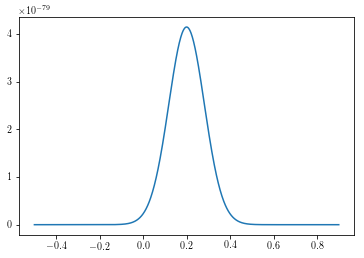

In [147]:
x = np.linspace(-0.5, 0.9, 1001)
y = np.exp(-x**2/2/tau**2)*(b + (39.6 - 2*10.2*x + n*x**2)**2/2)**(-a-n/2)
plt.plot(x,y, label = r"p(\mu)")
plt.show()

The sample distribution for $\mu$:

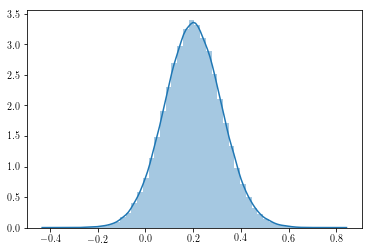

In [152]:
sns.distplot(samples2[:,0], norm_hist=True, label="histogram")
plt.show()

The marginal density of $\lambda$:

\begin{align}
p(\lambda | data) &\propto \lambda^{n/2+a-1} e^{-\lambda b} 
\int e^{-\frac{1}{2} (\mu - \frac{\lambda n \bar{x}}{1/\tau^2 + n \lambda})^2 \cdot (1/\tau^2 + n \lambda)} d\mu\\
                    &\propto \frac{\lambda^{n/2+a-1} e^{-\lambda b}}{\sqrt{1/\tau^2 + n\lambda}}
\end{align}

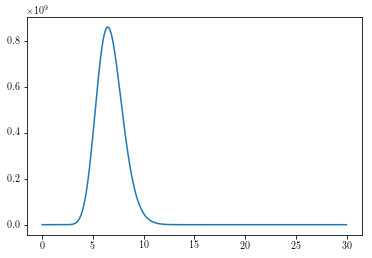

In [153]:
x = np.linspace(0,30,1001)
y = x**(n/2+a-1)*np.exp(-x*b)/np.sqrt(1/tau**2+n*x) * np.exp(-(10.2*x)**2/(n*x+1/tau**2)/2)
plt.plot(x, y)
plt.show()

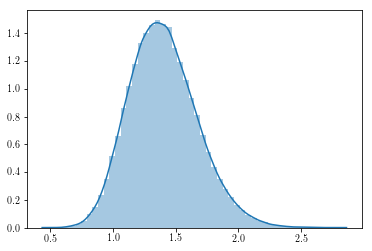

In [154]:
sns.distplot(samples2[:,1])
plt.show()

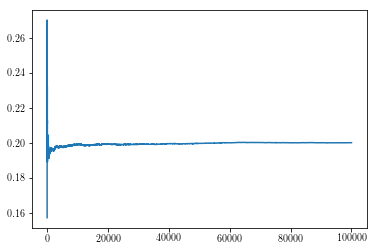

In [155]:
mu = samples2[:,0].copy()
lamda = samples2[:,1].copy()

for i in range(1, N2):
    mu[i] = (mu[i-1]*i + samples2[i, 0])/(i+1)
    lamda[i] = (lamda[i-1]*i + samples2[i,1])/(i+1)
    
plt.plot(range(N2), mu)
plt.show()

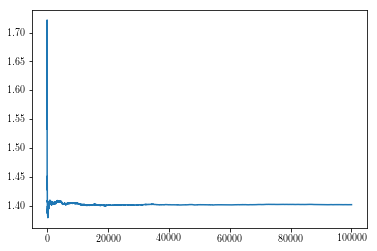

In [156]:
plt.plot(range(N2), lamda)
plt.show()

In [157]:
1/samples2[-10000:].mean(axis=0)

array([ 4.98308556,  0.71415972])

In [158]:
(39.6 - 2*0.2*10.2 + n*0.2**2)/(n-1)

0.7512000000000001

## 3.

Note that the initial position matters in this problem

In [21]:
alpha3 = 3

In [22]:
def pi(k):
    return 1/np.power(k, alpha3)

In [23]:
def q(x2, x1):
    assert abs(x2-x1) == 1
    if x2 == 2 and x1 == 1:
        return 1
    return 1/2

In [24]:
def alpha(x2, x1):
    
    return min(1, pi(x2) / pi(x1) * q(x1, x2) / q(x2, x1))

In [25]:
x1 = 1
N3 = 10000
samples3 = np.zeros(N3)
for i in range(N3):
    x2_tmp = 2 if x1 == 1 else np.random.choice([x1+1, x1-1])
    u = np.random.uniform()
    x2 = x2_tmp if u < alpha(x2_tmp, x1) else x1
    x1 = x2
    samples3[i] = x2

In [26]:
samples3

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

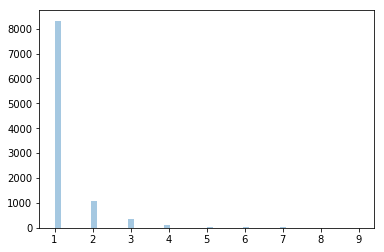

In [27]:
sns.distplot(samples3, kde=False)
#plt.plot(range(1,17), 1/np.power(range(1,17), 3))

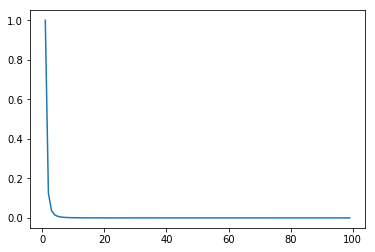

In [34]:
X3 = range(1, 100)
plt.plot(X3, 1/np.power(X3, 3))

## 4.

In [112]:
def pi4(x, y):
    return np.exp(-4*x-3*y*np.exp(x))

def q4(x2, x1):
    return 1/x2 * np.exp(-1/2 * (np.log(x2) - np.log(x1))**2)

def alpha4(x2, x1, y):
    return min(1, pi4(x2, y) / pi4(x1, y) * x2/x1)

In [127]:
def MH_x(x, y):
    x_tmp = np.random.lognormal(np.log(x), 1)
    u = np.random.uniform()
    x = x_tmp if u < alpha4(x_tmp, x, y) else x
    return x

def draw_y(x):
    return np.random.gamma(shape = 4, scale = 1/3/np.exp(x))

In [147]:
N4 = 100000
samples4 = np.zeros((N4, 2))
x = 1
y = np.random.gamma(4, 5)
for i in range(N4):
    y = draw_y(x)
    x = MH_x(x, y)
    samples4[i, 0] = x
    samples4[i, 1] = y

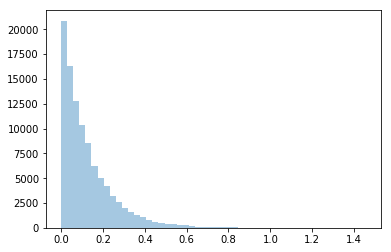

In [148]:
sns.distplot(samples4[:,0], kde=False)

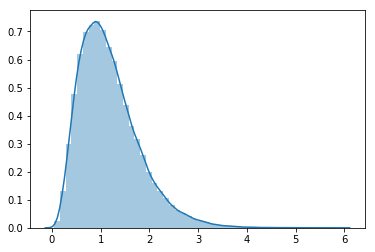

In [149]:
sns.distplot(samples4[:, 1])

In [150]:
(samples4[:,0] * samples4[:,1]).mean()

0.13202225070870988

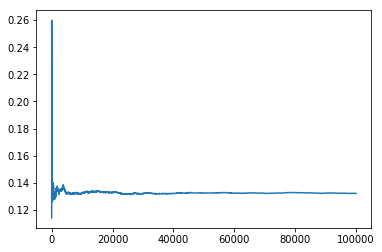

In [151]:
I4 = (samples4[:,0] * samples4[:,1])
for i in range(1, N):
    I4[i] = (samples4[:i,0]*samples4[:i,1]).mean()
    
plt.plot(range(N4), I4)

In [152]:
(samples4[20000:,0] * samples4[20000:,1]).mean()

0.13180364238209383